<a href="https://colab.research.google.com/github/gulabpatel/Graph_Neural_Network/blob/main/GNN_AnomalyDetection/03_Fraud_Detection_with_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries and Functions**

In [ ]:
import numpy as np
import pandas as pd
import warnings
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCN
from torch_geometric.nn import GNNExplainer
from datetime import datetime
from pyTigerGraph.gds.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,15)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, roc_curve, precision_recall_curve, f1_score

def threshold_search(y_true, y_proba):
        precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
        thresholds = np.append(thresholds, 1.0001)
        F = 2 / (1/precision + 1/recall)
        best_score = np.max(F)
        best_th = thresholds[np.argmax(F)]
        return best_th

log_dir = "work/" + datetime.now().strftime("%Y%m%d-%H%M%S")
train_log = SummaryWriter(log_dir+"/train")
valid_log = SummaryWriter(log_dir+"/valid")

def sample_vertex():
    for i in range(100):
        node_idx = int(np.random.choice(np.where(y_pred1==1)[0],1))
        try:
            x, edge_index = batch.x, batch.edge_index
            explainer = GNNExplainer(model, epochs=1)
            node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
            ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=batch.y)
            return node_idx
        except:
            pass

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


## **Connect to TigerGraph Database**

In [ ]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="", # Change the address to your database server's
    graphname="",
    username="",
    password=""
)
conn.apiToken = conn.getToken("", 86400)

## **Add Degree Features inside TigerGraph**

In [ ]:
conn.runInstalledQuery("degrees")

[{'"Success !"': 'Success !'}]

## **Add Amounts Features inside TigerGraph**

In [ ]:
conn.runInstalledQuery("amounts")

[{'"Success!"': 'Success!'}]

## **Check Count of Positive Labels**

In [ ]:
conn.getVertexCount("Account","is_fraud = 1")

1165

## **Check Count of Negative Labels**

In [ ]:
conn.getVertexCount("Account","is_fraud = 0")

31002

## **Run Train-Test Split inside TigerGraph**

In [ ]:
%%time
split = conn.gds.vertexSplitter(is_training=0.8, is_validation=0.2)
split.run()

/opt/conda/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


Splitting vertices...
Vertex split finished successfully.
CPU times: user 542 ms, sys: 305 ms, total: 847 ms
Wall time: 1.18 s


## **Add PageRank Features inside TigerGraph**

In [ ]:
feat = conn.gds.featurizer()
feat.installAlgorithm("tg_pagerank")
tg_pagerank_params = {
  "v_type": "Account",
  "e_type": "Transaction",
  "result_attr": "pagerank",
  "top_k":5
}
results = pd.json_normalize(feat.runAlgorithm("tg_pagerank",tg_pagerank_params)[0]['@@top_scores_heap'])
results

,Vertex_ID,score
0,0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5,741.64771
1,0x47779ea9849c7eec04197b21f9554931b8fcd5f4,607.40985
2,0xbfa82fbe0e66d8e2b7dcc16328db9ecd70533d13,212.12177
3,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,179.57887
4,0x5df65e16d6ec1a8090ffa11c8185ad372a8786cd,173.80971


## **Add Hyperparameters for NeighborSampler and Graph Neural Network**

In [ ]:
# Hyperparameters
hp = {"batch_size": 5000, "num_neighbors": 200, "num_hops": 3, "hidden_dim": 128, "num_layers": 2, "dropout": 0.05, "lr": 0.0075, "l2_penalty": 5e-5}

## **Define Train Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [ ]:
train_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_training",
    shuffle=True,
    timeout=600000
)

## **Define Validation Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [ ]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_validation",
    shuffle=True,
    timeout=600000
)

## **Define Graph Convolutional Network Architecture using PyTorch Geometric**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(
    in_channels=7,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=2,
    dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

## **Run Training Loop with AUC, AUCPR, Precision and Recall as Metrics**

In [ ]:
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    print("Start Training epoch:", epoch)
    model.train()
    epoch_train_loss = Accumulator()

    epoch_train_auc = []
    epoch_train_prec = []
    epoch_train_rec = []
    epoch_train_apr = []
    epoch_best_thr = []

    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    for bid, batch in enumerate(train_loader):
        # print(bid, batch)
        if (batch.y.sum()==0):
            continue
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        batch.x = batch.x.type(torch.FloatTensor)
        batch.y = batch.y.type(torch.LongTensor)

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.edge_weight)
        # Calculate loss
        class_weight = torch.FloatTensor([1.0, 15.0])
        loss = F.cross_entropy(out[batch.is_training], batch.y[batch.is_training], class_weight)
        # f1_loss(batch.y[batch.is_training], out[batch.is_training], is_training=True)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_training][:,1].cpu().numpy()
            y_true = batch.y[batch.is_training].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_training][:,1].cpu().numpy()
            best_threshold = threshold_search(y_true, y_pred)
            y_pred1 = (y_pred > best_threshold).astype(int)

            epoch_train_auc.append(roc_auc_score(y_true, y_pred))
            epoch_train_prec.append(precision_score(y_true, y_pred1))
            epoch_train_rec.append(recall_score(y_true, y_pred1))
            epoch_train_apr.append(average_precision_score(y_true, y_pred))
            epoch_best_thr.append(best_threshold)

        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["auc"] = np.mean(epoch_train_auc)
        logs["prec"] = np.mean(epoch_train_prec)
        logs["rec"] = np.mean(epoch_train_rec)
        logs["apr"] = np.mean(epoch_train_apr)
        logs["thr"] = np.mean(epoch_best_thr)

        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, AUC {:.4f}, AUCPR {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
                epoch, bid, logs["loss"], logs["auc"], logs["apr"], logs["prec"], logs["rec"]
            )
        )
        train_log.add_scalar("Loss", logs["loss"], global_steps)
        train_log.add_scalar("AUC", logs["auc"], global_steps)
        train_log.add_scalar("AUCPR", logs["apr"], global_steps)
        train_log.flush()
        global_steps += 1
    # Evaluate
    print("Start validation epoch:", epoch)
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_prec = []
    epoch_val_rec = []
    epoch_val_auc = []
    epoch_val_apr = []

    for batch in valid_loader:
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        with torch.no_grad():
            # Forward pass
            batch.x = batch.x.type(torch.FloatTensor)
            batch.y = batch.y.type(torch.LongTensor)
            out = model(batch.x, batch.edge_index)
            # Calculate loss
            class_weight = torch.FloatTensor([1.0, 20.0])
            valid_loss = F.cross_entropy(out[batch.is_validation], batch.y[batch.is_validation], class_weight)
            # f1_loss(batch.y[batch.is_validation], out[batch.is_validation])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_validation][:,1].cpu().numpy()
            y_true = batch.y[batch.is_validation].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_validation][:,1].cpu().numpy()
            y_pred1 = (y_pred > np.mean(epoch_best_thr)).astype(int)

            epoch_val_auc.append(roc_auc_score(y_true, y_pred))
            epoch_val_prec.append(precision_score(y_true, y_pred1))
            epoch_val_rec.append(recall_score(y_true, y_pred1))
            epoch_val_apr.append(average_precision_score(y_true, y_pred))

    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_prec"] = np.mean(epoch_val_prec)
    logs["val_auc"] = np.mean(epoch_val_auc)
    logs["val_rec"] = np.mean(epoch_val_rec)
    logs["val_apr"] = np.mean(epoch_val_apr)
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid AUC {:.4f}, Valid AUCPR {:.4f}, Valid Precision {:.4f}, Valid Recall {:.4f}".format(
            epoch, logs["val_loss"], logs["val_auc"], logs["val_apr"], logs["val_prec"], logs["val_rec"]
        )
    )
    valid_log.add_scalar("Loss", logs["val_loss"], global_steps)
    valid_log.add_scalar("AUC", logs["val_auc"], global_steps)
    valid_log.add_scalar("AUCPR", logs["val_apr"], global_steps)
    valid_log.flush()

Start Training epoch: 0
Epoch 0, Train Batch 0, Loss 0.6978, AUC 0.5632, AUCPR 0.0737, Precision 0.1720, Recall 0.0691
Epoch 0, Train Batch 1, Loss 0.6842, AUC 0.7571, AUCPR 0.3658, Precision 0.4251, Recall 0.3569
Epoch 0, Train Batch 2, Loss 0.6718, AUC 0.8258, AUCPR 0.4803, Precision 0.5329, Recall 0.4613
Epoch 0, Train Batch 3, Loss 0.6605, AUC 0.8606, AUCPR 0.5368, Precision 0.6013, Recall 0.5011
Epoch 0, Train Batch 4, Loss 0.6496, AUC 0.8812, AUCPR 0.5728, Precision 0.6396, Recall 0.5366
Epoch 0, Train Batch 5, Loss 0.6392, AUC 0.8950, AUCPR 0.5948, Precision 0.6690, Recall 0.5514
Start validation epoch: 0
Epoch 0, Valid Loss 0.5382, Valid AUC 0.9707, Valid AUCPR 0.7672, Valid Precision 0.3476, Valid Recall 0.8661
Start Training epoch: 1
Epoch 1, Train Batch 0, Loss 0.5655, AUC 0.9668, AUCPR 0.7226, Precision 0.7798, Recall 0.6628
Epoch 1, Train Batch 1, Loss 0.5551, AUC 0.9691, AUCPR 0.7340, Precision 0.7983, Recall 0.6635
Epoch 1, Train Batch 2, Loss 0.5449, AUC 0.9686, AUCPR 0

## **Define and Run Explainability Model**

Explain node 4303: 100% 1/1 [00:00<00:00, 134.97it/s]
Explain node 4303: 100% 100/100 [00:00<00:00, 226.56it/s]


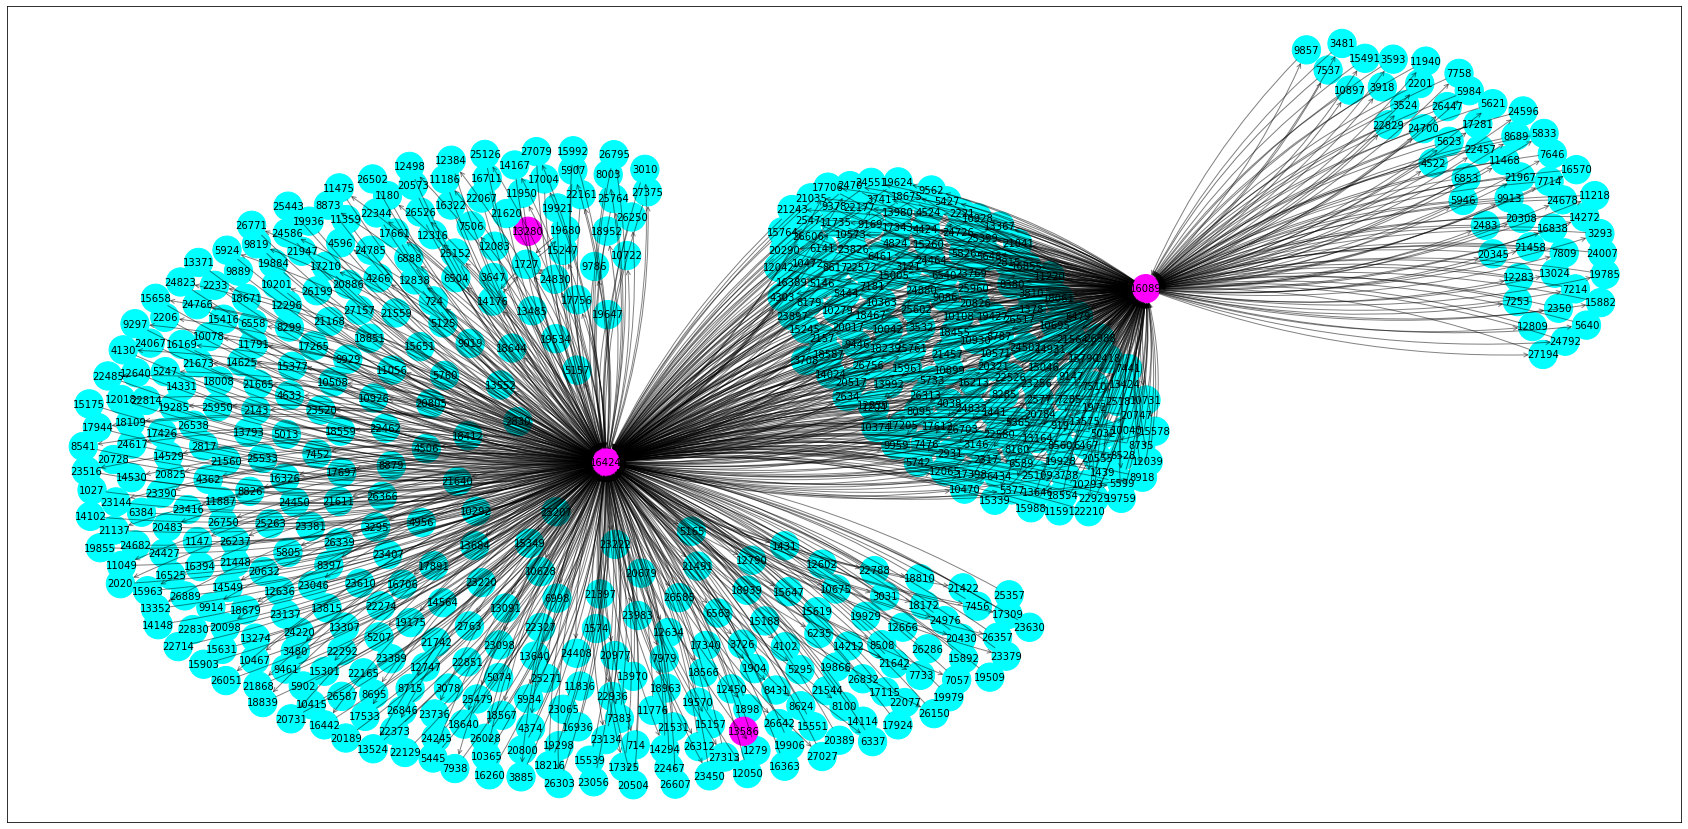

In [ ]:
node_idx = sample_vertex()
x, edge_index = batch.x, batch.edge_index
explainer = GNNExplainer(model, epochs=100)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

## **Show Local Feature Importance**

Explain node 16424: 100% 100/100 [00:01<00:00, 79.68it/s]
Explain node 16089: 100% 100/100 [00:00<00:00, 259.86it/s]

---- Normalized Feature Importance
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
Account ID,,,,,,,
4303,0.246572,0.712181,0.733618,0.260401,0.254661,0.275504,0.722594
16424 (16424),0.730702,0.268578,0.255523,0.245975,0.730027,0.294349,0.289655
16089 (16089),0.760887,0.261722,0.273178,0.266076,0.717297,0.254782,0.256013


---- Normalized Feature Values
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
4303,0.354323,0.223192,0.220467,0.0,0.121372,9.430661e-08,0.080645
4303,0.228971,0.014255,0.375532,0.0,0.354962,0.000000e+00,0.026280


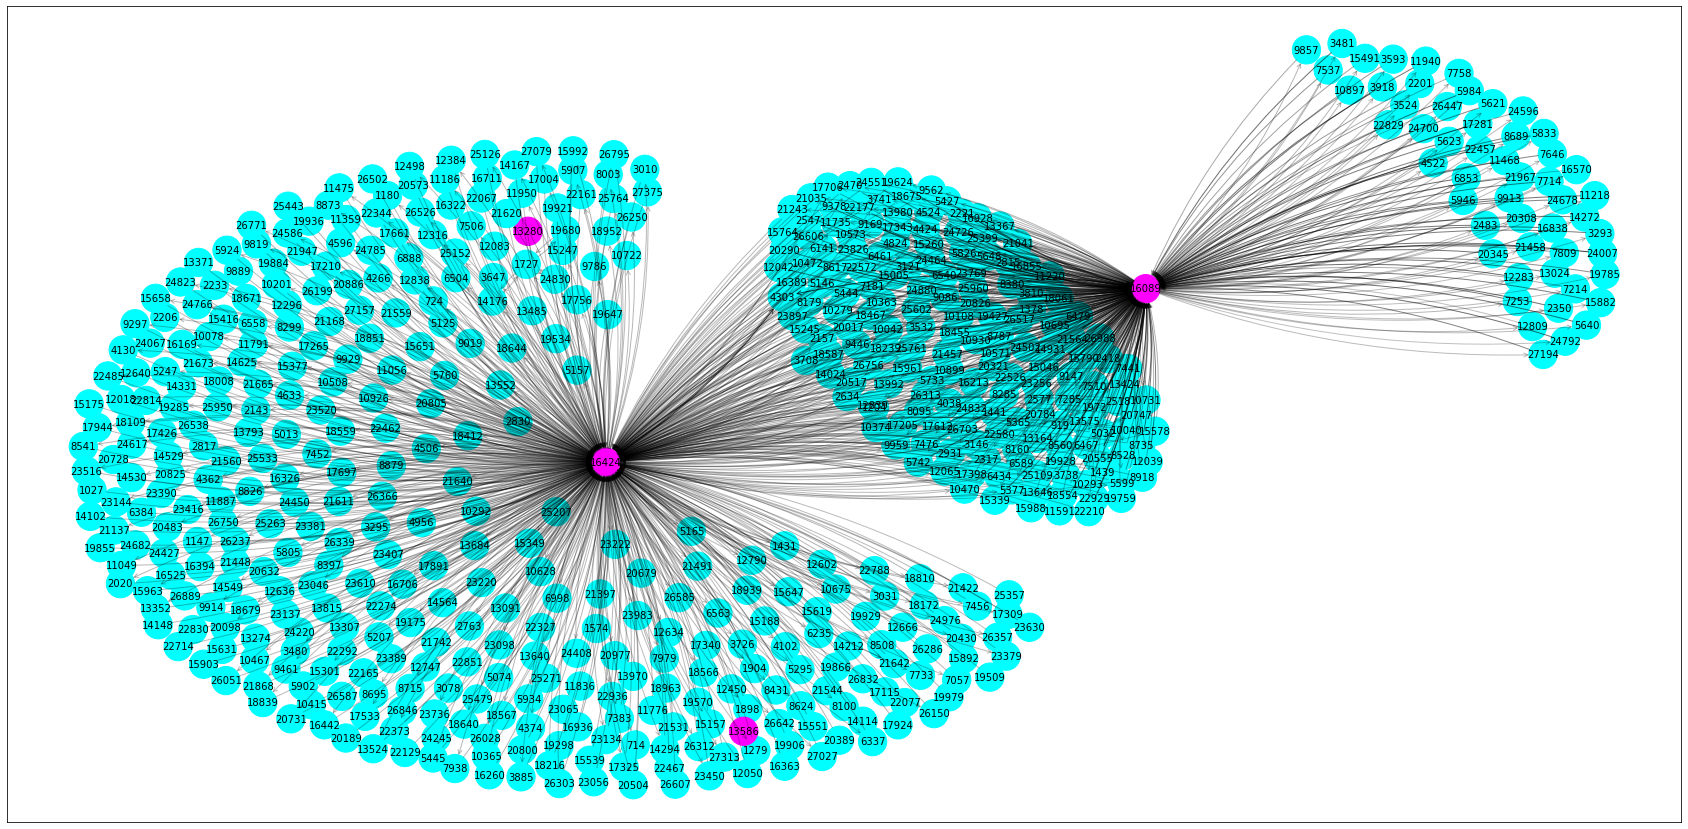

In [ ]:
import pandas as pd
from IPython.display import display

ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y = batch.y)
feature_values = list()
feature_values.append(["{}".format(node_idx)] + node_feat_mask.tolist())  # Center ID
important_accounts = set()
for src, dst, attr in G.edges(data=True):
    edge_importance = attr["att"]
    if edge_importance >= 0.001:
        if src == node_idx:
            important_accounts.add(dst)
        elif dst == node_idx:
            important_accounts.add(src)

subg_accts = list(important_accounts)
for acct_idx in important_accounts:
    target_id = acct_idx
    node_feat_mask, _ = explainer.explain_node(acct_idx, x, edge_index)
    feature_values.append(["{} ({})".format(target_id, acct_idx)] + node_feat_mask.tolist())
feature_names = ['in_degree', 'out_degree', 'send_amount', 'send_min', 'recv_amount', 'recv_min', 'pagerank']
df = pd.DataFrame(feature_values, columns=["Account ID"] + feature_names).set_index("Account ID")
print("---- Normalized Feature Importance")
print(" ")
display(df.style.background_gradient(axis=1))
print("---- Normalized Feature Values")
print(" ")
feature_df = pd.DataFrame(batch.x.cpu().numpy(), columns = feature_names)
display(feature_df.loc[subg_accts].rename(index=lambda acct: "{}".format(node_idx)))